In [1]:
import torch
import captum 
from Process_Data.audio_processing import read_WaveInt
from TrainAndTest.common_func import load_model_args
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
data = read_WaveInt('/home/yangwenhao/dataset/voxceleb2/dev/aac/id00012/21Uxsk56VDQ/00001.wav')
data = data[:, :160000]
print(data.shape)

(1, 150528)


In [6]:
baselines = []
with open('baselines.txt', 'r') as f:
    for l in f.readlines():
        uid, upath = l.split()
        the_data = read_WaveInt(upath)
        while the_data.shape[1] < data.shape[1]:
            the_data = np.concatenate([the_data, the_data], axis=1)
        
        the_data = trans(torch.tensor(the_data[:, :data.shape[1]]).reshape(1, 1, 1, -1).float())
        baselines.append(the_data)

In [7]:
baselines = torch.cat(baselines, dim=0)

In [4]:
model_kwargs = load_model_args('../../Data/checkpoint/ThinResNet34_ser07/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/model.2023.05.08.yaml')
if 'embedding_model' in model_kwargs:
    model = model_kwargs['embedding_model']
    if 'classifier' in model_kwargs:
        model.classifier = model_kwargs['classifier']
        
checkpoint = torch.load('../../Data/checkpoint/ThinResNet34_ser07/Mean_batch128_cbam_downk5_avg0_SAP2_em256_dp01_alpha0_none1_chn32_wde4_varesmix8/arcsoft_sgd_rop/vox2/wave_sp161_dist/123456/checkpoint_15.pth')
checkpoint_state_dict = checkpoint['state_dict']
if isinstance(checkpoint_state_dict, tuple):
    checkpoint_state_dict = checkpoint_state_dict[0]

filtered = {k: v for k, v in checkpoint_state_dict.items() if 'num_batches_tracked' not in k}
if list(filtered.keys())[0].startswith('module'):
    new_state_dict = OrderedDict()
    for k, v in filtered.items():
        name = k[7:]  # remove `module.`，表面从第7个key值字符取到最后一个字符，去掉module.
        new_state_dict[name] = v  # 新字典的key值对应的value为一一对应的值。

    model.load_state_dict(new_state_dict)
else:
    model_dict = model.state_dict()
    model_dict.update(filtered)
    model.load_state_dict(model_dict)

In [5]:
model = model.eval()

trans = model.input_mask[0]
model.input_mask.__delitem__(0)

model.return_embeddings = False

In [8]:
input_data = torch.tensor(data.reshape(1, 1, 1, -1)).float()
input_data = trans(input_data)

In [9]:
class model_forward():
    def __init__(self, model):
        self.model = model
        pass
    
    def __call__(self, data):
        logits,_ = self.model(data)
        
        return logits

In [29]:
def reverse(data):
    data = data.detach().squeeze().T.numpy()
    return np.flip(data, axis=0)

def clip_sum_norm(grad):
    cam = np.clip(grad, a_min=0, a_max=None).sum(axis=0)
    cam = (cam - cam.min()) / (cam.max()-cam.min() + 1e-6)
    return cam

In [11]:
def plot_input_cam(data, cam):
    plt.figure(figsize=(8, 3))

    plt.subplot(2,1,1)
    plt.imshow(reverse(data))
    _ = plt.xticks([])
    _ = plt.yticks([])

    plt.subplot(2,1,2)
    plt.imshow(reverse(cam))
    _ = plt.xticks([])
    _ = plt.yticks([])
    plt.tight_layout()

### 1. Gradient

In [14]:
Saliency = captum.attr.Saliency(model)

In [15]:
gradient = Saliency.attribute(input_data, target=0)

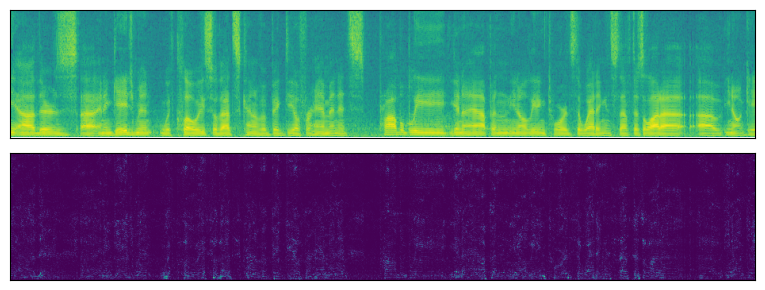

In [16]:
plot_input_cam(input_data, gradient)

### 2. Input * Gradient

In [18]:
InputSaliency = captum.attr.InputXGradient(model)

In [19]:
insa = InputSaliency.attribute(input_data, target=0)

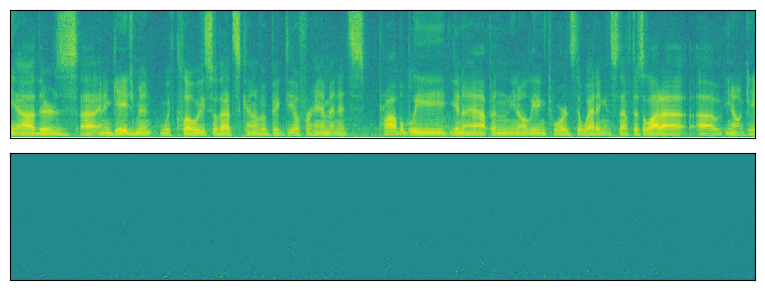

In [20]:
plot_input_cam(input_data, insa)

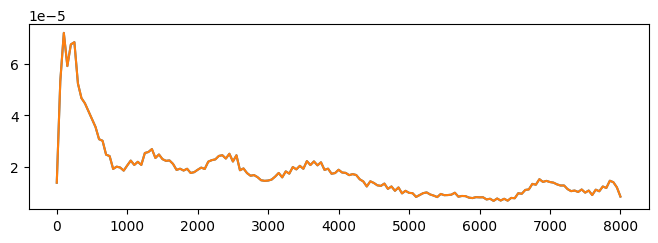

In [21]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)

plt.plot(x, gradient.detach().squeeze().mean(dim=0))
plt.plot(x, insa.detach().squeeze().mean(dim=0))

### 3. InteGrad

In [22]:
InteGrad = captum.attr.IntegratedGradients(model)

In [23]:
ingd = InteGrad.attribute(input_data, baselines.mean(dim=0, keepdim=True),
                          target=0)

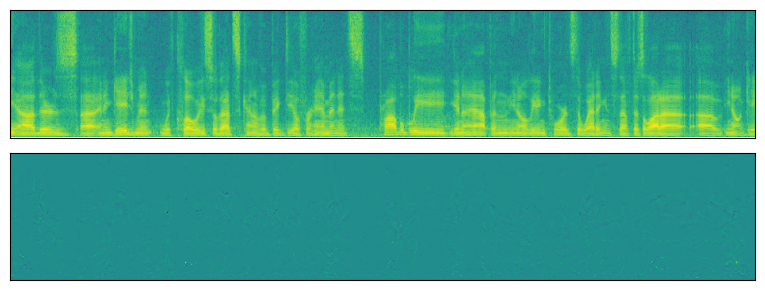

In [24]:
plot_input_cam(input_data, ingd)

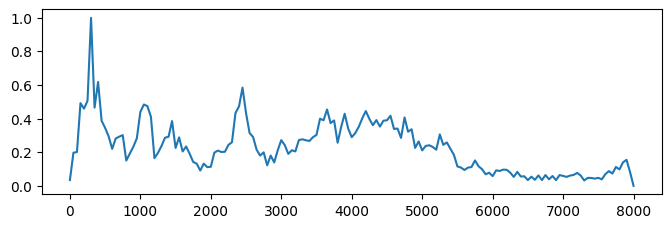

In [31]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)

y = ingd.detach().squeeze() #.mean(dim=0)
y = clip_sum_norm(y)
plt.plot(x, y)
# plt.plot(x, ingd.detach().squeeze().std(dim=0))

### 4. DeepLift

In [ ]:
deeplift = captum.attr.DeepLift(model)
dplf = deeplift.attribute(input_data, target=0)

In [ ]:
plot_input_cam(input_data, dplf)

In [ ]:
plt.figure(figsize=(8, 2.4))
x = np.linspace(0, 8000, 161)
plt.plot(x, dplf.detach().squeeze().mean(dim=0))

### 5. DeepLiftShap

In [ ]:
deepliftshp = captum.attr.DeepLiftShap(model)

dplp = deepliftshp.attribute(input_data, baselines, target=0)

In [ ]:
plt.figure(figsize=(8, 2.4))

x = np.linspace(0, 8000, 161)
plt.plot(x, dplp.detach().squeeze().mean(dim=0))

### 6. GradientShap

In [26]:
gradshap = captum.attr.GradientShap(model)

gdsp = gradshap.attribute(input_data, baselines, target=0)

In [76]:
gdsp.shape

torch.Size([1, 1, 941, 161])

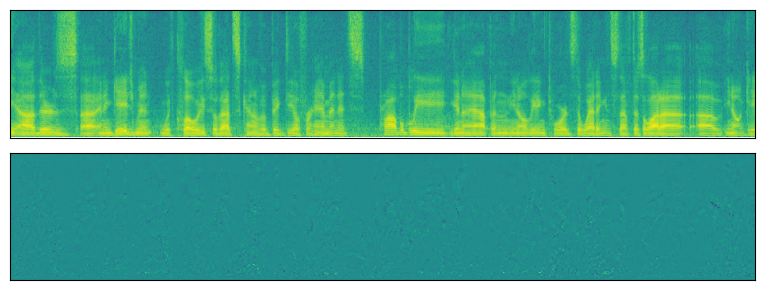

In [27]:
plot_input_cam(input_data, gdsp)

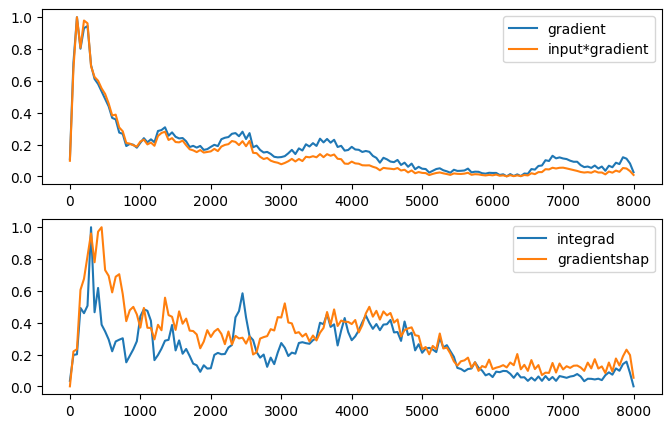

In [38]:
plt.figure(figsize=(8, 5))
x = np.linspace(0, 8000, 161)

plt.subplot(2,1,1)
y = gradient.detach().squeeze()
y = clip_sum_norm(y)
plt.plot(x, y)

plt.subplot(2,1,1)
y = insa.detach().squeeze()
y = clip_sum_norm(y)
plt.plot(x, y)
plt.legend(['gradient', 'input*gradient'])

plt.subplot(2,1,2)
y = ingd.detach().squeeze() #.mean(dim=0)
y = clip_sum_norm(y)
plt.plot(x, y)

plt.subplot(2,1,2)
y = gdsp.detach().squeeze() #.mean(dim=0)
y = clip_sum_norm(y)
plt.plot(x, y)
plt.legend(['integrad', 'gradientshap'])

# plt.plot(x, gdsp.detach().squeeze().std(dim=0))

# integrad 和 gradientshap 看似好于一般gradient方法

### 7. Occlusion

In [ ]:
occl = captum.attr.Occlusion(model)

ocgd = occl.attribute(input_data, sliding_window_shapes=(1,5,5), target=0)